In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import zscore
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
train= pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test= pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [54]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

(None, None)

In [7]:
train.isnull().sum() * 100 /len(train)

Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
                   ...    
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
Length: 81, dtype: float64

In [55]:
def remove_nans(data, thresh):
    def nans_rate(data, col):
        return data[col].isna().sum() / data.shape[0]

    for col in data.columns:
        if nans_rate(data, col) >= thresh:
            data.drop(col, axis=1, inplace=True)

    return data

train = remove_nans(train, 0.7)
test = remove_nans(test, 0.7)
train.shape, test.shape

((1460, 77), (1459, 76))

In [56]:
train['SalePrice'].isna().sum()

0

In [9]:
num_cols = train.select_dtypes(include='number').columns
num_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [10]:
cat_cols = train.select_dtypes(include="object").columns
cat_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
# # Define a function to remove outliers using Box-Cox transformation
# def remove_outliers_boxcox(data):
#     # Added a small constant to handle zero and negative values--close to one
#     data = data - data.min() + 1e-6
#     transformed_data, _ = boxcox(data)
#     return transformed_data

# # Apply Box-Cox transformation to numerical columns
# transformed_num_cols = train[num_cols].apply(remove_outliers_boxcox)
# transformed_num_cols

In [12]:
for col in train.columns:
    if col in num_cols:
        median_value = train[col].median()
        train[col] = train[col].fillna(median_value)

In [13]:
for col in test.columns:
    if col in num_cols:
        median_value = test[col].median()
        test[col] = test[col].fillna(median_value)

In [14]:
for col in train.columns:
    if col in cat_cols:
        mode_value = train[col].mode()[0]
        train[col] = train[col].fillna(mode_value)

In [15]:
for col in test.columns:
    if col in cat_cols:
        mode_value = test[col].mode()[0]
        test[col] = test[col].fillna(mode_value)

In [16]:
# Check if there are any remaining missing values
print("Remaining missing values:\n", train.isnull().sum())

Remaining missing values:
 Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 77, dtype: int64


In [17]:
# Check if there are any remaining missing values
print("Remaining missing values:\n", test.isnull().sum())

Remaining missing values:
 Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 76, dtype: int64


In [18]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1460.0,69.863699,22.027677,21.0,60.00,69.0,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


## Univariate Analysis

In [19]:
# check unique values in dataset
train[cat_cols].apply(lambda x: len(x.unique()))

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        3
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

# exploratory data analysis (EDA) 

Street
Pave    1454
Grvl       6
Name: count, dtype: int64


Text(0.5, 0, 'Street')

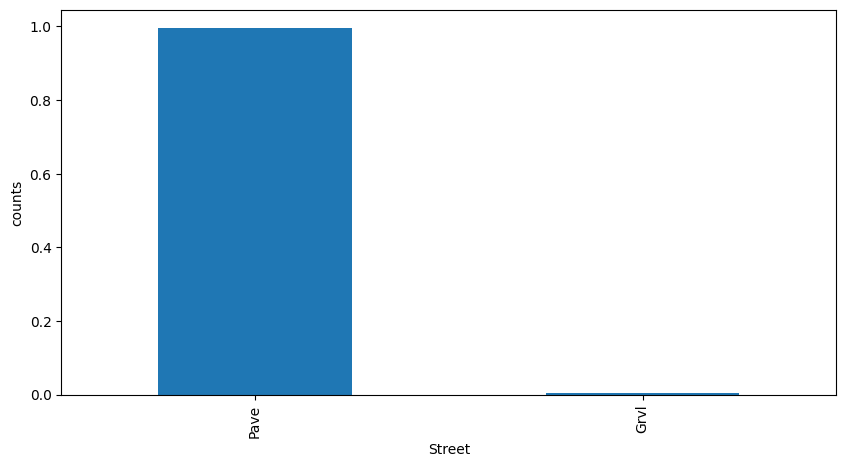

In [20]:
print(train['Street'].value_counts())
plt.figure(figsize=(10,5))
train['Street'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Street')

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64


Text(0.5, 0, 'MSZoning')

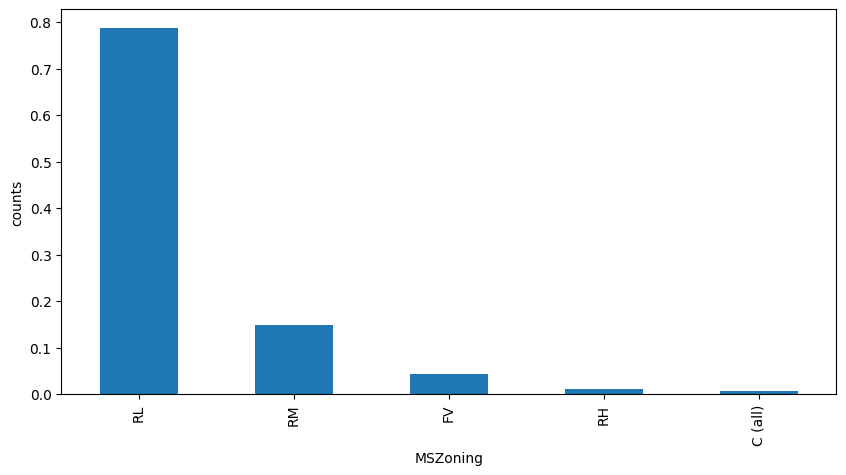

In [21]:
print(train['MSZoning'].value_counts())
plt.figure(figsize=(10,5))
train['MSZoning'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('MSZoning')

LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64


Text(0.5, 0, 'LotShape')

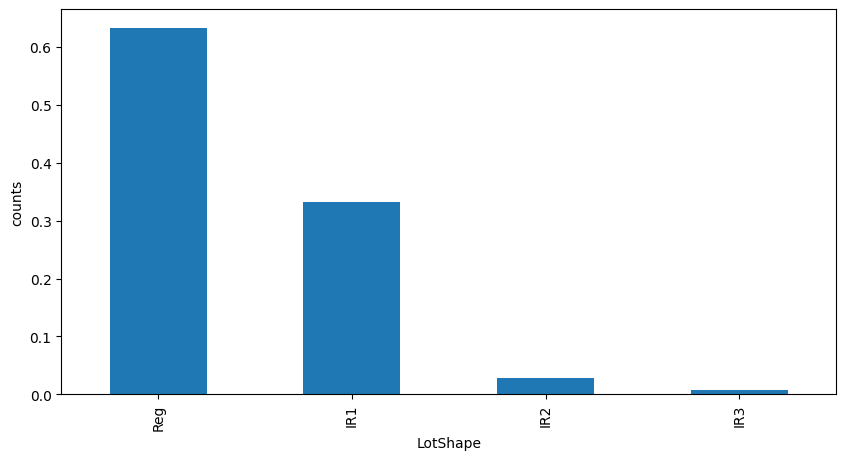

In [22]:
print(train['LotShape'].value_counts())
plt.figure(figsize=(10,5))
train['LotShape'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('LotShape')

Heating
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: count, dtype: int64


Text(0.5, 0, 'Heating')

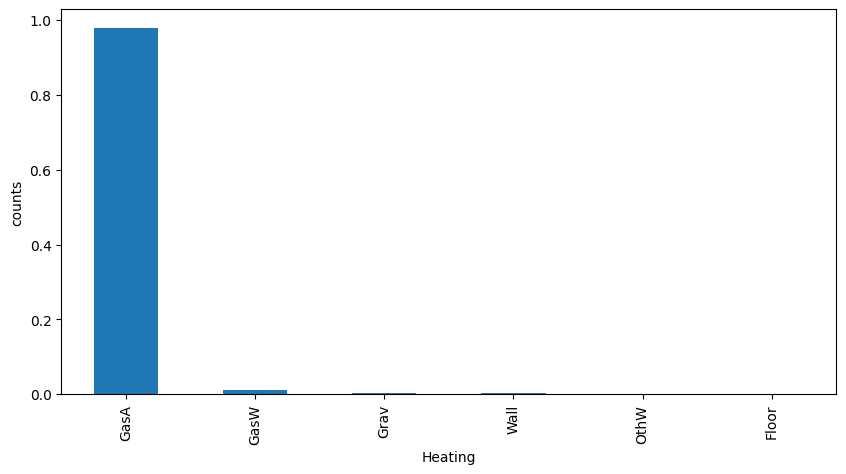

In [23]:
print(train['Heating'].value_counts())
plt.figure(figsize=(10,5))
train['Heating'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Heating')

Foundation
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: count, dtype: int64


Text(0.5, 0, 'Foundation')

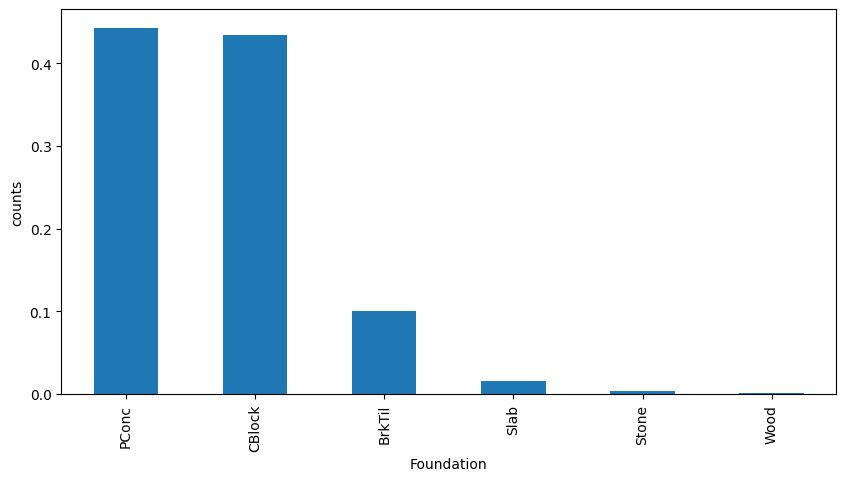

In [24]:
print(train['Foundation'].value_counts())
plt.figure(figsize=(10,5))
train['Foundation'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Foundation')

Electrical
SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64


Text(0.5, 0, 'Electrical')

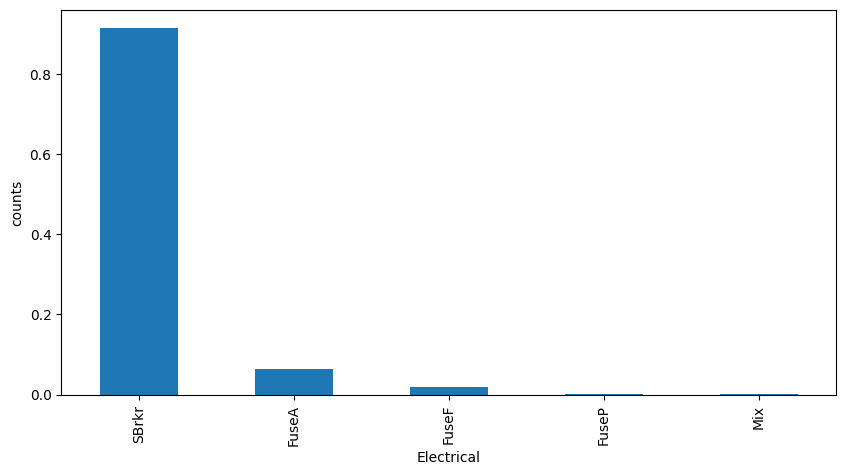

In [25]:
print(train['Electrical'].value_counts())
plt.figure(figsize=(10,5))
train['Electrical'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Electrical')

KitchenQual
TA    735
Gd    586
Ex    100
Fa     39
Name: count, dtype: int64


Text(0.5, 0, 'KitchenQual')

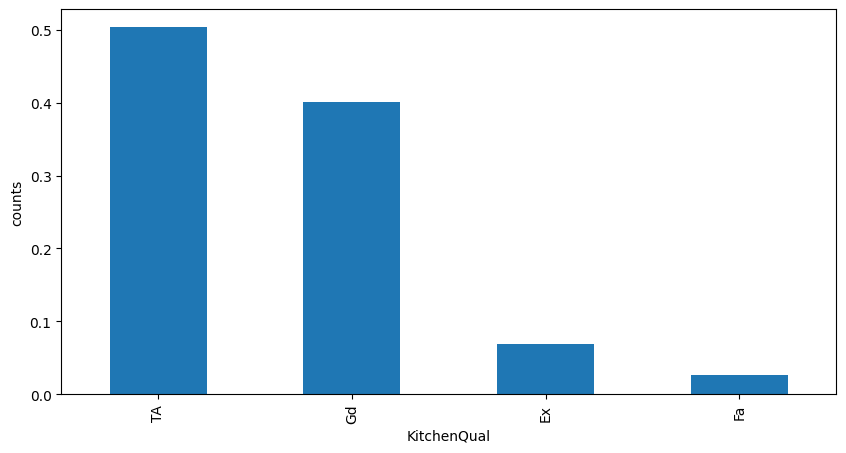

In [26]:
print(train['KitchenQual'].value_counts())
plt.figure(figsize=(10,5))
train['KitchenQual'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('KitchenQual')

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64


Text(0.5, 0, 'Neighborhood')

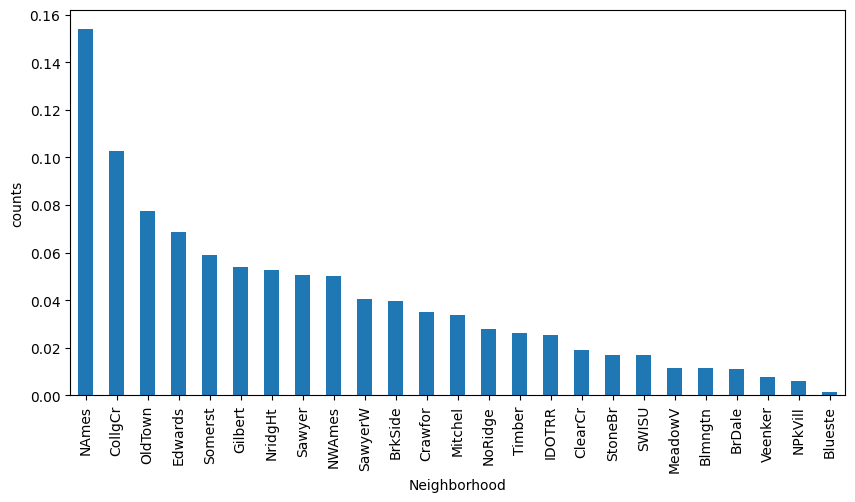

In [27]:
print(train['Neighborhood'].value_counts())
plt.figure(figsize=(10,5))
train['Neighborhood'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Neighborhood')

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64


Text(0.5, 0, 'LandContour')

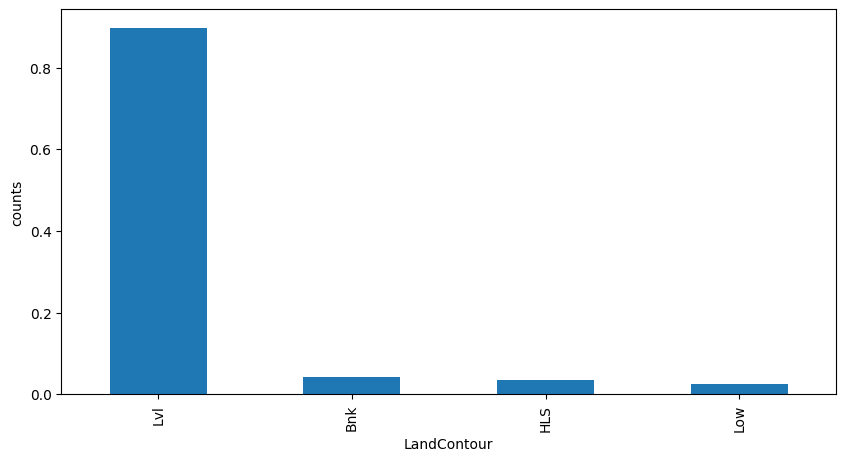

In [28]:
print(train['LandContour'].value_counts())
plt.figure(figsize=(10,5))
train['LandContour'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('LandContour')

SaleType
WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: count, dtype: int64


Text(0.5, 0, 'SaleType')

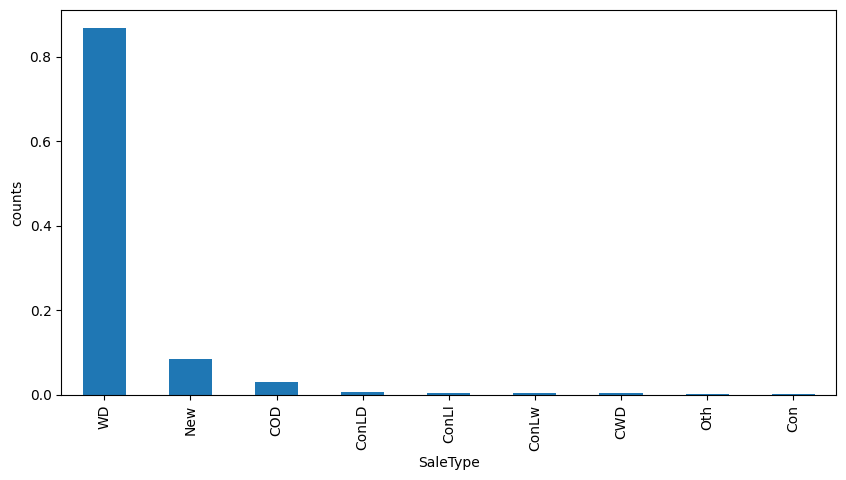

In [29]:
print(train['SaleType'].value_counts())
plt.figure(figsize=(10,5))
train['SaleType'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('SaleType')

SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64


Text(0.5, 0, 'SaleCondition')

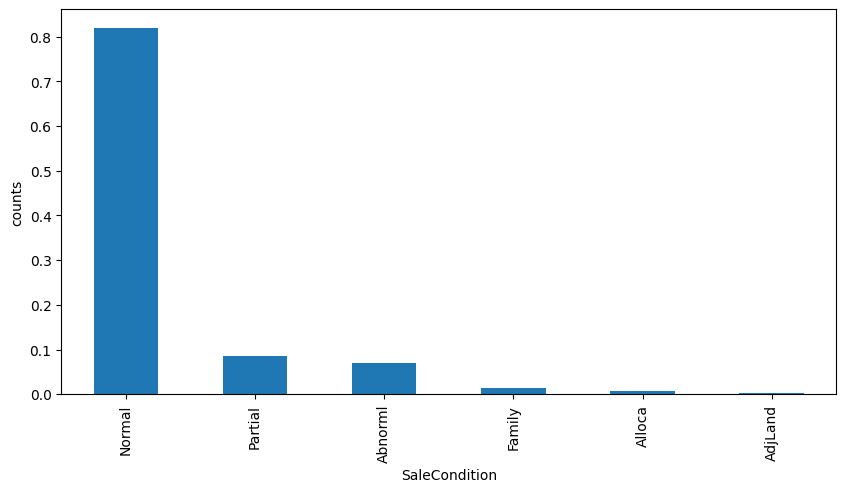

In [30]:
print(train['SaleCondition'].value_counts())
plt.figure(figsize=(10,5))
train['SaleCondition'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('SaleCondition')

In [31]:
# # Plot boxplots of the transformed columns
# plt.figure(figsize=(12, 8))
# plt.boxplot(transformed_num_cols.values, labels=num_cols, vert=False)
# plt.title('Boxplot after Box-Cox Transformation')
# plt.xlabel('Transformed Values')
# plt.show()

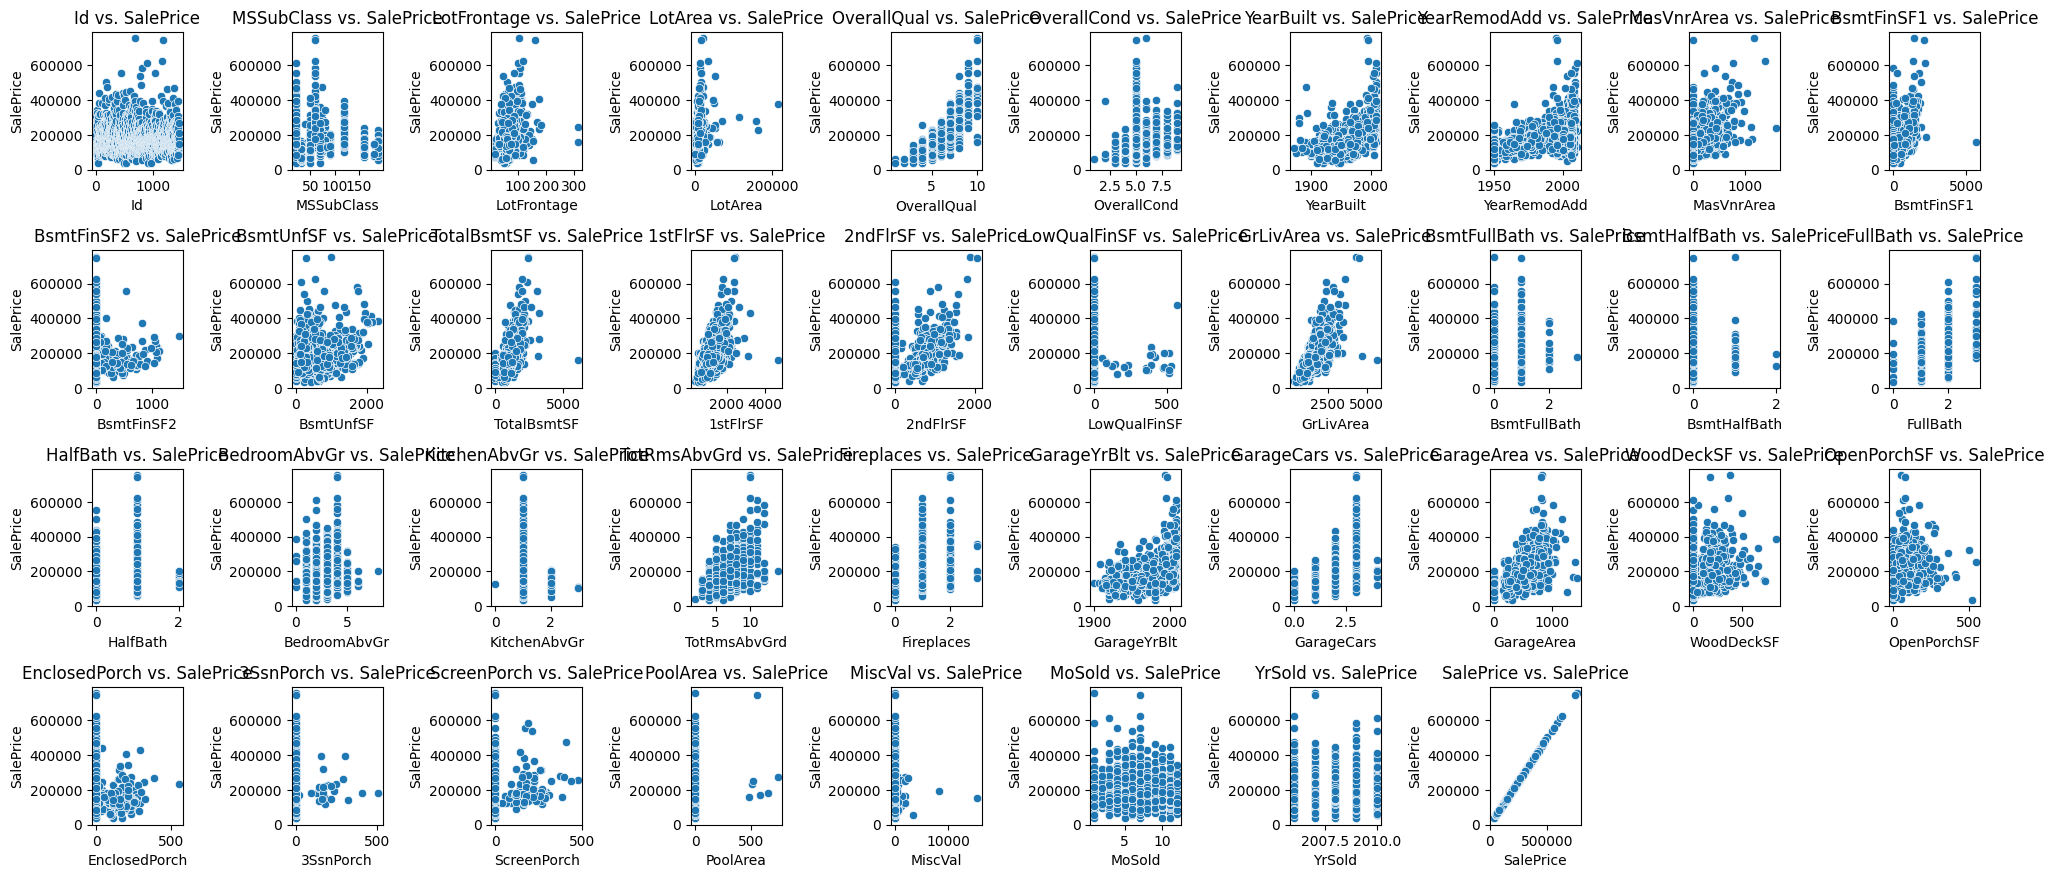

In [32]:
# Scatter plots of numerical features against the target variable (SalePrice)
plt.figure(figsize=(20, 15))
for i, column in enumerate(num_cols, 1):
    plt.subplot(7, 10, i)
    sns.scatterplot(x=train[column], y=train['SalePrice'])
    plt.title(f'{column} vs. SalePrice')
plt.tight_layout()
plt.show()

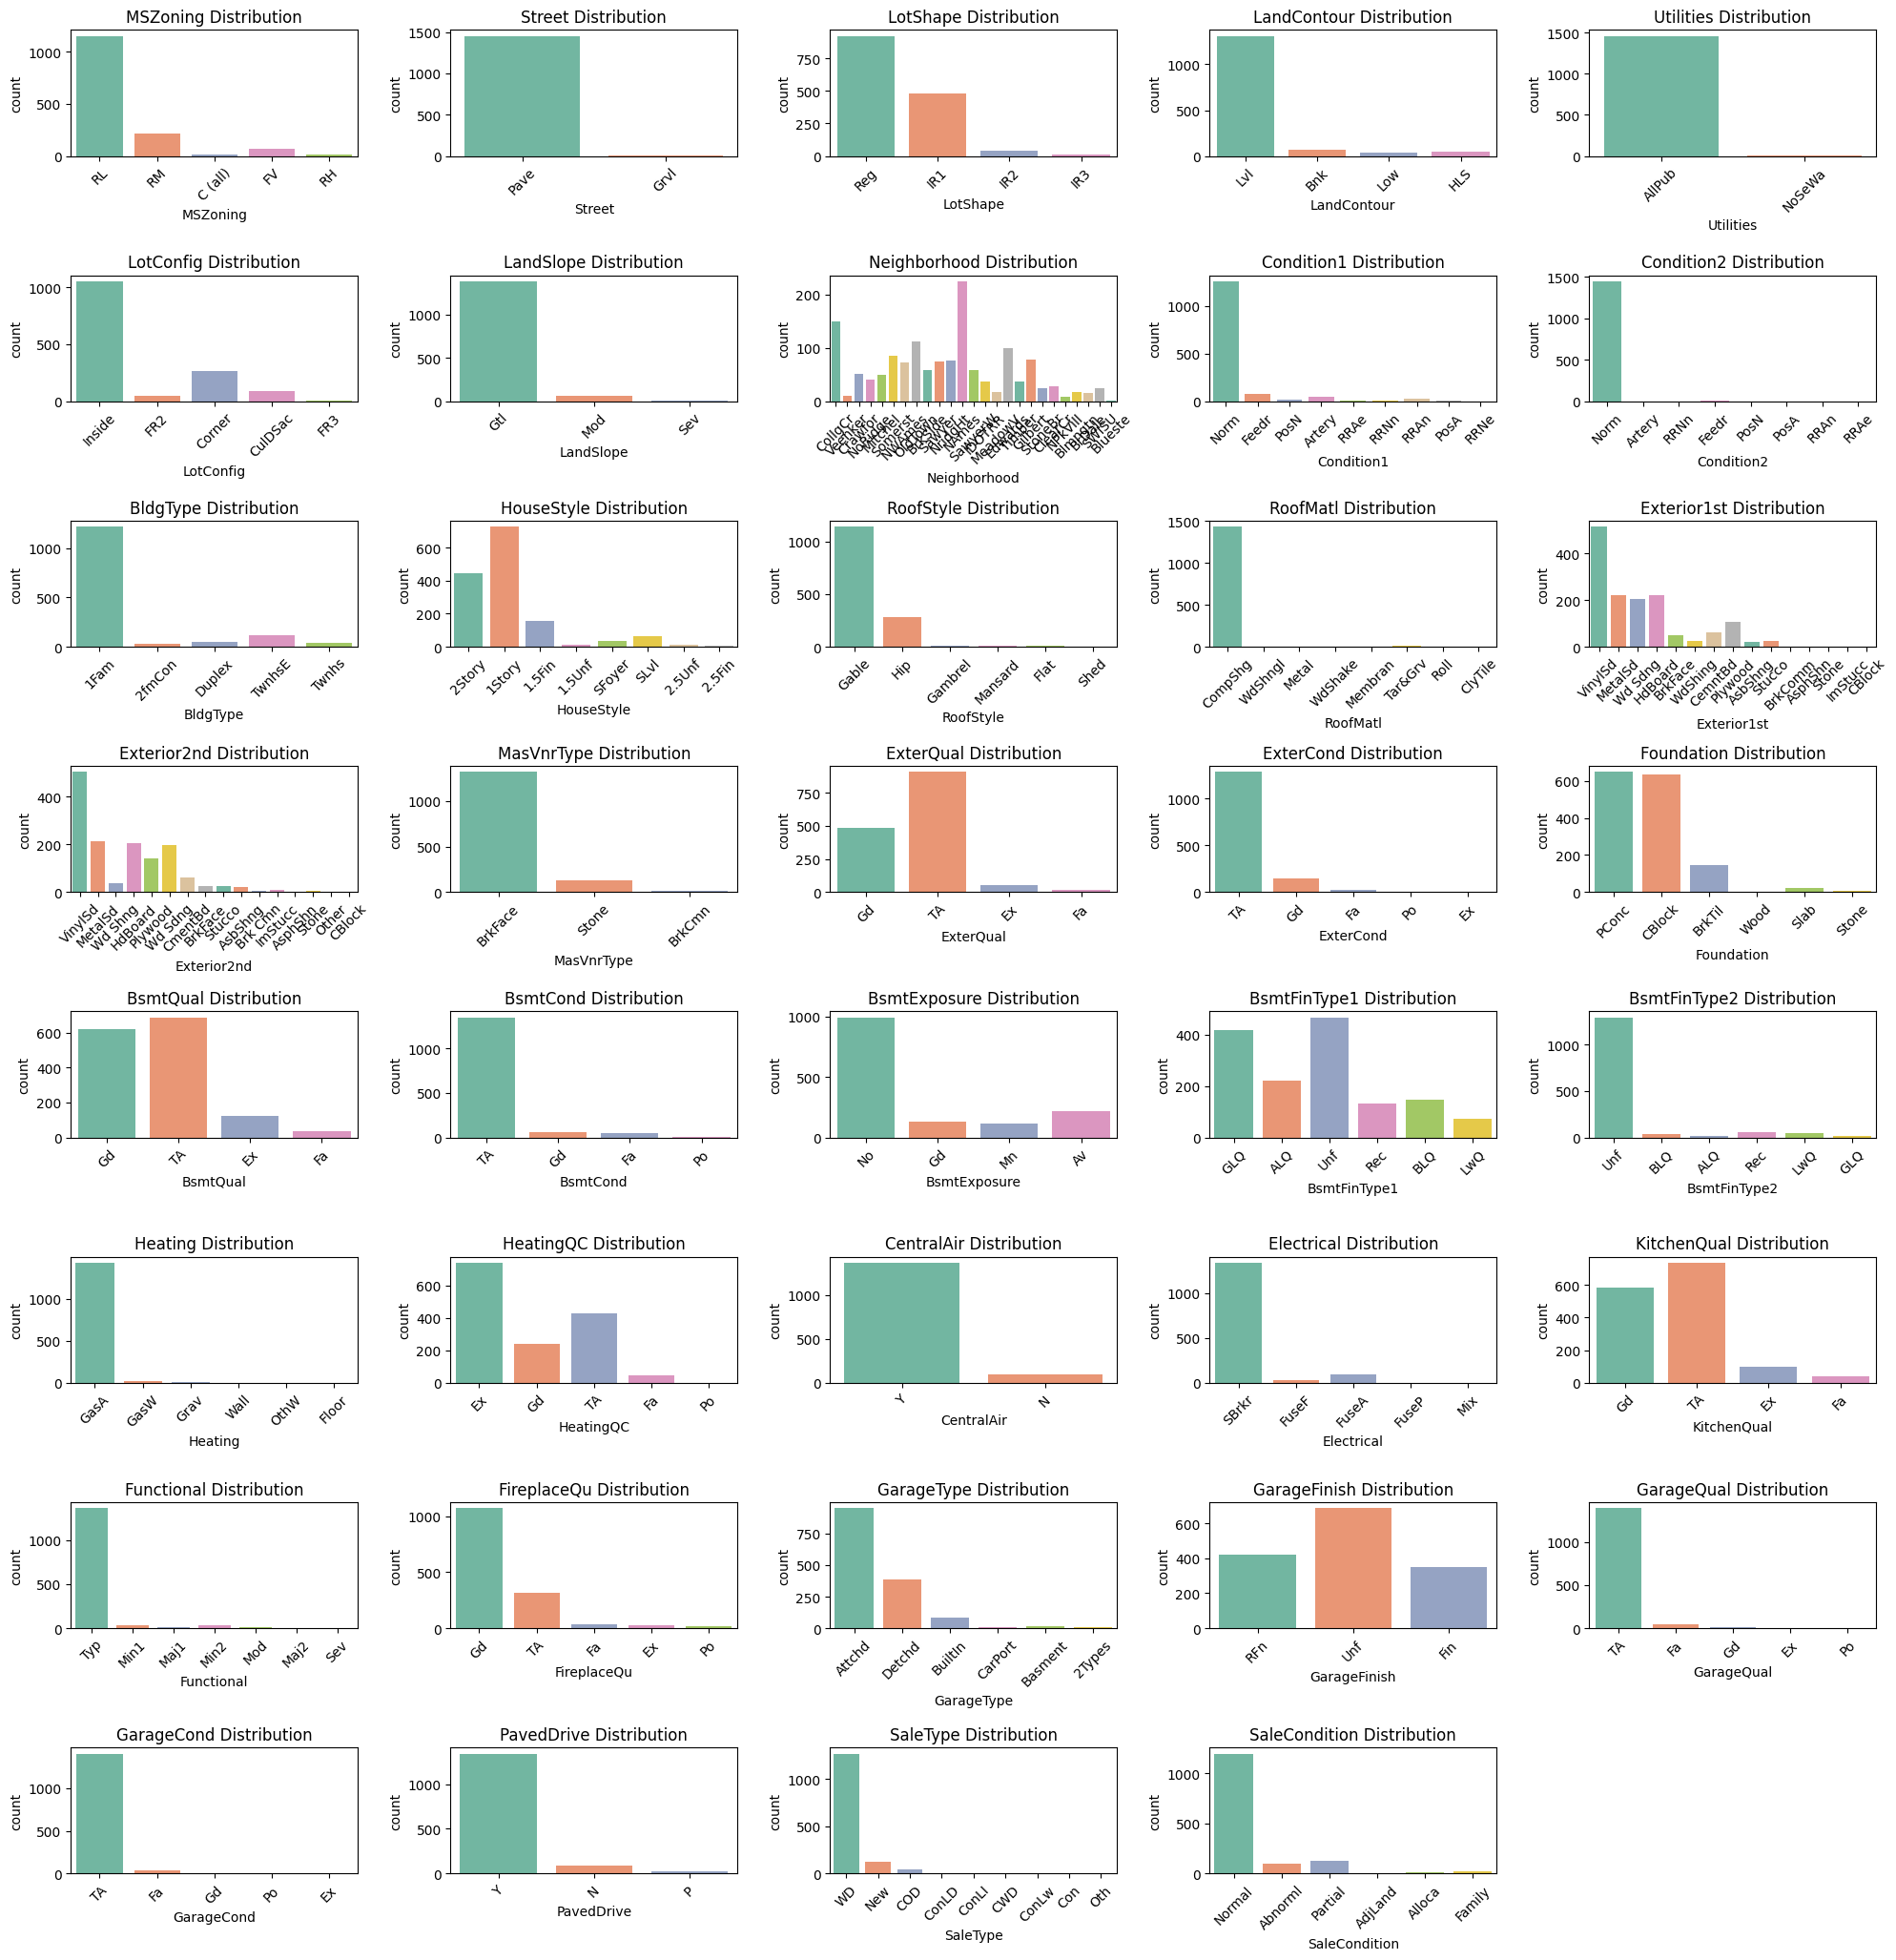

In [33]:
# Bar plots of categorical features
plt.figure(figsize=(20, 25))
for i, column in enumerate(cat_cols, 1):
    plt.subplot(10, 5, i)
    sns.countplot(x=column, data=train, palette="Set2")
    plt.title(f'{column} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
train[cat_cols].apply(lambda x: len(x.unique()))

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        3
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [59]:
# One-hot encode nominal columns
nominal_cols = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
                'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 
                'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 
                'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
dummies = pd.get_dummies(columns=nominal_cols, drop_first=True).astype(int)

TypeError: get_dummies() missing 1 required positional argument: 'data'

In [37]:
le = LabelEncoder()

le_columns = [col for col in train.select_dtypes('object').columns]

for col in le_columns:
    train[col] = le.fit_transform(train[col])

In [38]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,...,0,0,0,0,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,3,3,0,2,...,0,0,0,0,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,0,3,0,4,...,0,0,0,0,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,0,3,0,0,...,272,0,0,0,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,0,3,0,2,...,0,0,0,0,0,12,2008,8,4,250000.0


In [39]:
# Split the dataset into features (X) and target variable (y)
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

In [44]:
X

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,3,65.0,8450,1,3,3,0,4,...,61,0,0,0,0,0,2,2008,8,4
1,2,20,3,80.0,9600,1,3,3,0,2,...,0,0,0,0,0,0,5,2007,8,4
2,3,60,3,68.0,11250,1,0,3,0,4,...,42,0,0,0,0,0,9,2008,8,4
3,4,70,3,60.0,9550,1,0,3,0,0,...,35,272,0,0,0,0,2,2006,8,0
4,5,60,3,84.0,14260,1,0,3,0,2,...,84,0,0,0,0,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,4,21.0,1936,1,3,3,0,4,...,0,0,0,0,0,0,6,2006,8,4
1455,2916,160,4,21.0,1894,1,3,3,0,4,...,24,0,0,0,0,0,4,2006,8,0
1456,2917,20,3,160.0,20000,1,3,3,0,4,...,0,0,0,0,0,0,9,2006,8,0
1457,2918,85,3,62.0,10441,1,3,3,0,4,...,32,0,0,0,0,700,7,2006,8,4


In [40]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2335, 76), (584, 76), (2335,), (584,))

In [53]:
data['SalePrice'].isnull().sum()

1459

In [50]:
import catboost as catt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from functools import partial

In [52]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_pred = []
oof_pred = np.zeros(len(X))  # Initialize the array to store out-of-fold predictions
lgb_mae = []
catt_mae = []
params = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'random_state': [42]
}

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initializing our models
    model_1 = lgb.LGBMRegressor(random_state=42)
    model_3 = catt.CatBoostRegressor(random_state=42)

    # Wrap LGBMRegressor's fit method to enable early stopping
    fit_with_early_stopping = partial(
        lgb.LGBMRegressor.fit,
        eval_set=[(X_test, y_test)],
        eval_metric='mae',
#         verbose=False
    )

    # Fitting our models
    fit_with_early_stopping(model_1, X_train, y_train)
    model_3.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    # Making predictions
    pred_1 = model_1.predict(X_test)
    pred_3 = model_3.predict(X_test)

    # Calculate MAE for each model
    lgb_mae.append(mean_absolute_error(y_test, pred_1))
    catt_mae.append(mean_absolute_error(y_test, pred_3))

    # Ensemble predictions
    ensemble_pred = (pred_1 + pred_2 + pred_3) / 3
    fold_pred.append(ensemble_pred)
    
    # Out-of-fold predictions
    oof_pred[test_index] = ensemble_pred
    
# Concatenate predictions across folds
fold_pred = np.concatenate(fold_pred)

# Calculate overall mean absolute error (MAE) across folds for ensemble model
overall_mae = mean_absolute_error(y, oof_pred)

print("Overall Mean Absolute Error (Ensemble):", overall_mae)
print("Mean Absolute Error (LightGBM):", np.mean(lgb_mae))
print("Mean Absolute Error (CatBoost):", np.mean(catt_mae))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3883
[LightGBM] [Info] Number of data points in the train set: 2335, number of used features: 72
[LightGBM] [Info] Start training from score 90073.093362


CatBoostError: /src/catboost/catboost/libs/metrics/metric.cpp:6766: metric/loss-function RMSE do not allows nan value on target

In [ ]:
# Make predictions on the testing set
y_pred = linear_reg_model.predict(X_test_scaled)

In [ ]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Specify the degree of the polynomial
degree = 2

# Create a pipeline for Polynomial Regression
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model to the training data
poly_model.fit(X_train_scaled, y_train)


In [ ]:
# Evaluate the model score on the testing data
poly_model_score = poly_model.score(X_test_scaled, y_test)
print("Polynomial Regression Score:", poly_model_score)

In [ ]:
# Make predictions on the test data
poly_predictions = poly_model.predict(X_test_scaled)

In [ ]:
# Calculate evaluation metrics
poly_mse = mean_squared_error(y_test, poly_predictions)
poly_rmse = np.sqrt(poly_mse)
poly_mae = mean_absolute_error(y_test, poly_predictions)
poly_r2 = r2_score(y_test, poly_predictions)

print("Polynomial Regression Metrics:")
print("Mean Squared Error:", poly_mse)
print("Root Mean Squared Error:", poly_rmse)
print("Mean Absolute Error:", poly_mae)
print("R-squared:", poly_r2)

In [ ]:
from sklearn.linear_model import Lasso

# Initialize Lasso Regression model
lasso_model = Lasso(alpha=0.01)  # You can tune the alpha parameter
lasso_model.fit(X_train_scaled, y_train)

In [ ]:
# Make predictions
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate metrics
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression Metrics:")
print("Mean Squared Error:", mse_lasso)
print("Mean Absolute Error:", mae_lasso)
print("R-squared:", r2_lasso)

In [ ]:
from sklearn.linear_model import Ridge

# Initialize Ridge Regression model
ridge_model = Ridge(alpha=0.01)  # You can tune the alpha parameter
ridge_model.fit(X_train_scaled, y_train)

In [ ]:
# Make predictions
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Calculate metrics
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Metrics:")
print("Mean Squared Error:", mse_ridge)
print("Mean Absolute Error:", mae_ridge)
print("R-squared:", r2_ridge)

Fine-Tuning: Experiment with different regression algorithms and hyperparameters to improve model performance. Consider feature engineering techniques such as creating polynomial features or adding interaction terms.
Deployment: Once satisfied with the model performance, deploy the regression model to predict house prices for new data. Monitor model performance over time and update as necessary.